In [1]:
import pickle, mne, os, random, warnings, copy, sys, shutil# done in mac m1
import numpy as np # done in mac m1
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import svm
from scipy import signal
from itertools import chain
import matplotlib.pyplot as plt
from scipy.integrate import simps  # not done
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix,\
accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from scipy.integrate import simps
import sklearn.model_selection as model_selection
from sklearn.decomposition import FastICA
from mne.filter import filter_data as bandpass_filter
from scipy.signal import welch, butter, lfilter, sosfilt, sosfreqz, freqz
from scipy.integrate import simps
from scipy.stats import f_oneway
from mne.preprocessing import ICA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from skfeature.utility.construct_W import construct_W
from scipy.sparse import diags
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')

In [2]:
def get_feature(data):
    channel_no = [0, 2, 16, 19] # only taking these four channels
    feature_vector = [6.2, 7.3, 6.2, 7.3]
    counter_patient = 0
    total_channel_no = 4
    feature = np.ones(40*len(feature_vector)*total_channel_no).reshape(40,len(feature_vector)*total_channel_no)
    feature_matrix = []
    for ith_video in range(40):
        features = []
        for ith_channel in channel_no:
            # power spectral density
            # please refer: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.psd.html
            psd, freqs = plt.psd(data[ith_video][ith_channel], Fs = 128)
            # get frequency bands mean power
            theta_mean = np.mean(psd[np.logical_and(freqs >= 4, freqs <= 7)])
            alpha_mean = np.mean(psd[np.logical_and(freqs >= 8, freqs <= 13)])
            beta_mean  = np.mean(psd[np.logical_and(freqs >= 13, freqs <= 30)])
            gamma_mean = np.mean(psd[np.logical_and(freqs >= 30, freqs <= 40)])
            features.append([theta_mean, alpha_mean, beta_mean, gamma_mean])
        # flatten the features i.e. transform it from 2D to 1D
        feature_matrix.append(np.array(list(chain.from_iterable(features))))
    return np.array(feature_matrix)

In [3]:
def get_class_labels(labels, class_type):
    # encoding
    emotion = np.ones(40)
    if(class_type=='valence'):
        for i in range(0, 40):
            if labels[i][0]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    elif(class_type=='arousal'):
        for i in range(40):
            if labels[i][1]>=5:
                emotion[i] = 0
            else:
                emotion[i] = 1
    else:
        for i in range(40):
            if(labels[i][0]>=5 and labels[i][1] >=5): # HVHA
                emotion[i] = 0
            elif(labels[i][0]>=5 and labels[i][1]<5): #HVLA
                emotion[i] = 1
            elif(labels[i][0]<5 and labels[i][1]>=5): #LVHA
                emotion[i] = 2
            else: #LVLA
                emotion[i] = 3
    return emotion

In [4]:
def get_four_class(val, ar):
    # decoding
    emotion = np.ones(val.shape[0])
    assert val.shape[0]==ar.shape[0]
    for i in range(0, val.shape[0]):
        if(val[i]==1 and ar[i]==1): # HVHA
            emotion[i] = 0
        elif(val[i]==1 and ar[i]==0): #HVLA
            emotion[i] = 1
        elif(val[i]==0 and ar[i]==1): #LVHA
            emotion[i] = 2
        else: #LVLA
            emotion[i] = 3
    return emotion

In [5]:
N_C = None
droping_components = 'one'
def SignalPreProcess(eeg_rawdata):
    """
    :param eeg_rawdata: numpy array with the shape of (n_channels, n_samples)
    :return: filtered EEG raw data
    """
    assert eeg_rawdata.shape[0] == 32
    eeg_rawdata = np.array(eeg_rawdata)

    ch_names = ["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", 
                "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8",
                "PO4", "O2"]
  
    info = mne.create_info(ch_names = ch_names, ch_types = ['eeg' for _ in range(32)], sfreq = 128, verbose=False)
    raw_data = mne.io.RawArray(eeg_rawdata, info, verbose = False)
    raw_data.load_data(verbose = False).filter(l_freq = 4, h_freq = 48, method = 'fir', verbose = False)
    #raw_data.plot()

    ica = ICA(n_components = N_C, random_state = 97, verbose = False)
    ica.fit(raw_data)
    # https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html?highlight=find_eog_#mne.preprocessing.find_eog_events
    eog_indices, eog_scores = ica.find_bads_eog(raw_data.copy(), ch_name = 'Fp1', verbose = None)
    a = abs(eog_scores).tolist()
    if(droping_components == 'one'):
        ica.exclude = [a.index(max(a))]
        
    else: # find two maximum scores
        a_2 = a.copy()
        a.sort(reverse = True)
        exclude_index = []
        for i in range(0, 2):
            for j in range(0, len(a_2)):
                if(a[i]==a_2[j]):
                    exclude_index.append(j)
        ica.exclude = exclude_index
    ica.apply(raw_data, verbose = False)
    # common average reference
    raw_data.set_eeg_reference('average', ch_type = 'eeg')#, projection = True)
    filted_eeg_rawdata = np.array(raw_data.get_data())
    return filted_eeg_rawdata

def signal_pro(input_data):
    for i in range(input_data.shape[0]):
        input_data[i] = SignalPreProcess(input_data[i].copy())
    return input_data

In [6]:
def crossover(parent_1, parent_2, prob_cross):
    # perform crossover
    # parents: [a1, b1] & [a2, b2]
    # offspring: [a1, b2] & [a2, b1]
    if(prob_cross>=random.uniform(0, 1)):
        return [parent_1[0], parent_2[1], parent_1[2], parent_2[3]]
    else:
        return [parent_1[0], parent_1[1], parent_2[2], parent_2[3]]

def mutation(offsprings, prob_mut):
    # perform mutation
    for ind in range(0, len(offsprings)):
        if np.random.rand() <= prob_mut:
            act_or_solver = random.randint(2, 3)
            random_noise = random.randint(1, 4)
            offsprings[ind][act_or_solver] = int(offsprings[ind][act_or_solver]) + random_noise
    return offsprings

def compute_fitness(population, data):
    fitness = []
    for config in population:
        clf = MLPClassifier(learning_rate_init=0.09, activation=config[0], solver = config[1], alpha=1e-5,\
                            hidden_layer_sizes=(int(config[2]), int(config[3])),\
                            max_iter=1000, n_iter_no_change=80)
        clf.fit(data['trainX'], data['trainY'])
        fitness.append([accuracy_score(clf.predict(data['testX']), data['testY']), clf, list(config)])
    return np.array(fitness)

def initialize_population(pop_size):
    # Initialize the population
    activations = ['identity','logistic', 'tanh', 'relu']
    optimizers = ['lbfgs', 'sgd', 'adam']
    population = []
    for i in range(0, pop_size):
        rand_act = random.choice(activations)
        rand_opt = random.choice(optimizers)
        neurons_1st = random.randint(2, 100) # no of neurons in 1st layers
        neurons_2nd = random.randint(2, 50) # no of neurons in 2nd layers
        population.append(np.array([rand_act, rand_opt, neurons_1st, neurons_2nd]))
    return np.array(population)

def GA_MLP(data, generations, pop_size, prob_cross, prob_mut):
    population = initialize_population(pop_size) # Initialize new population
    pop_fitness = compute_fitness(population, data) # find the fitness of the population
    # sort the indivisuals based on their fitness function
    pop_sorted = np.array(list(reversed(sorted(pop_fitness, key=lambda ind: ind[0]))))
    for gen in range(0, generations):
        # parent selection
        parent_1 = pop_sorted[:,2][:pop_size//2] # take 1st half as parent-1
        parent_2 = pop_sorted[:,2][pop_size//2:] # take 2nd half as parent-2
        # crossover
        offsprings_1 = [crossover(parent_1[i], parent_2[i], prob_cross) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        offsprings_2 = [crossover(parent_2[i], parent_1[i], prob_cross) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        # mutation
        offsprings_1 = mutation(offsprings_1, prob_mut)
        offsprings_2 = mutation(offsprings_2, prob_mut)
        
        # calculates the fitness of the children to choose who will pass on to the next generation
        offsprings_1 = compute_fitness(offsprings_1, data)
        offsprings_2 = compute_fitness(offsprings_2, data)
        # concatenate all parents and new generated offsprings
        new_population = np.concatenate((pop_sorted, offsprings_1, offsprings_2))
        # sorted the merged population
        new_population = np.array(list(reversed(sorted(new_population, key=lambda x: x[0]))))
        # select individuals of the next generation with the same population size
        pop_sorted = new_population[0:pop_size, :]
    # return the predicted labels, trained with best classifier among all the generations
    return pop_sorted[0][1].predict(data['testX'])

# Main code

In [7]:
def get_four_class_performance(y_test_val, y_test_ar, y_pred_val, y_pred_ar):
    y_test_four = get_four_class(y_test_val, y_test_ar)
    y_pred_four = get_four_class(y_pred_val, y_pred_ar)
    
    four_acc = accuracy_score(y_test_four, y_pred_four)*100
    four_prec = precision_score(y_test_four, y_pred_four, labels=[0,1,2,3], average='weighted')*100
    four_recall = recall_score(y_test_four, y_pred_four, labels=[0,1,2,3], average='weighted')*100
    four_f1 = f1_score(y_test_four, y_pred_four, labels=[0,1,2,3], average='weighted')*100
    
    print(subject_no, four_acc, four_prec, four_recall, four_f1)

In [8]:
def emotion_classification(data, label):
    # train_test split
    x_train, x_test, y_train, y_test_val = model_selection.train_test_split(data, label, train_size=0.80,\
                                                                        test_size=0.20, random_state = 1000)
    data = dict(trainX=x_train, testX=x_test, trainY=y_train, testY=y_test_val)
    # GA optimized MLP
    y_pred = GA_MLP(data, generations = 50, pop_size = 20, prob_cross=0.95, prob_mut = 0.001)
    y_test = data['testY']
    acc = accuracy_score(y_pred, y_test)*100
    prec = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100
    print(subject_no, acc, prec, recall, f1)
    return y_test, y_pred

def get_data(subject_no):
    # read the data
    dataset_path = '/Users/shyammarjit/Desktop/Brain Computer Interface/Deap Dataset/'
    deap_dataset = pickle.load(open(dataset_path + subject_no + '.dat', 'rb'), encoding='latin1')
    # separate data and labels
    data = np.array(deap_dataset['data']) # for current data
    labels = np.array(deap_dataset['labels']) # for current labels
    # remove 3sec pre baseline
    data  = data[0:40,0:32,384:8064]
    # signal processing
    data = signal_pro(data)
    # feature extraction
    feature = get_feature(data)
    # class label
    four_class_labels = get_class_labels(labels, 'four_class')
    valence_labels = get_class_labels(labels, 'valence')
    arousal_labels = get_class_labels(labels, 'arousal')
    return feature, valence_labels, arousal_labels, four_class_labels

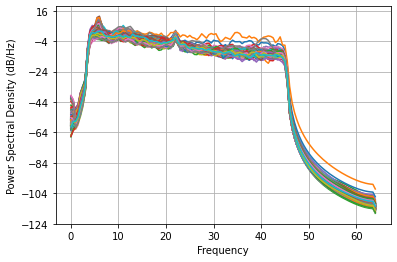

In [9]:
subject_no = 'S01'
data, valence_labels, arousal_labels, four_class_labels = get_data(subject_no)

In [10]:
test_val, pred_val = emotion_classification(data, valence_labels)

S01 87.5 100.0 80.0 88.8888888888889


In [13]:
test_ar, pred_ar = emotion_classification(data, arousal_labels)

S01 100.0 100.0 100.0 100.0


In [14]:
get_four_class_performance(test_val, test_ar, pred_val, pred_ar)

S01 87.5 81.25 87.5 83.33333333333334
